<a href="https://colab.research.google.com/github/angelohafner/linguagem-de-programacao-udesc/blob/main/iec_inverse_curves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
import numpy as np
import matplotlib.pyplot as plt

def get_iec_params(curve_type):
    ct = curve_type.upper()
    if ct == "NI":
        return 0.14, 0.02
    elif ct == "MI":
        return 13.5, 1.0
    elif ct == "EI":
        return 80.0, 2.0
    else:
        raise ValueError("Unsupported curve type.")


def iec_time(I_over_Iref, k, A, B, eps=1e-6):
    ratio = np.array(I_over_Iref, dtype=float)
    ratio = np.where(ratio <= 1.0 + eps, 1.0 + eps, ratio)
    return k * A / (np.power(ratio, B) - 1.0)


def plot_iec_inverse_with_tcc(
    Iref_list,
    k_list,
    Icc_list,
    tcc_list,
    Iref_labels=None,
    curve_type="NI",
    curto_max=None,
    rotulos_curto_max=None,
    cores_verticais=None,
    cores_L=None,
    titulo_grafico=None,
    n_points=4000
):

    Icc = np.array(Icc_list, dtype=float)
    tcc = np.array(tcc_list, dtype=float)
    n_def = len(Icc)

    # define colors for the L elements
    if cores_L is None:
        # fallback: usa cores padrão matplotlib
        cmap = plt.get_cmap("tab10")
        cores_L = [cmap(i % 10) for i in range(n_def)]
    else:
        if len(cores_L) != n_def:
            raise ValueError("cores_L must have the same length as Icc_list")

    has_inverse = (
        Iref_list is not None and
        k_list is not None and
        len(Iref_list) > 0 and len(k_list) > 0
    )

    if Iref_labels is None:
        labels = [f"Elem {i+1}" for i in range(n_def)]
    else:
        labels = Iref_labels

    if has_inverse:
        Iref = np.array(Iref_list, dtype=float)
        k    = np.array(k_list,    dtype=float)
        A, B = get_iec_params(curve_type)
        x_min = 1.05 * np.min(Iref)
    else:
        x_min = 0.8 * np.min(Icc)

    x_max = 1.5 * np.max(Icc)

    if has_inverse:
        I_full = np.linspace(x_min, x_max, n_points)

    plt.figure(figsize=(6.3, 10.2))

    # ============================================================
    # CASE 1 — COM CURVA IEC
    # ============================================================
    if has_inverse:

        t_global_min = None
        t_global_max = None

        for i in range(n_def):

            I_min_curve = 1.05 * Iref[i]
            Icc_eff = max(Icc[i], I_min_curve)

            ratio_full = I_full / Iref[i]
            t_full = iec_time(ratio_full, k[i], A, B)

            ratio_icc_eff = Icc_eff / Iref[i]
            t_icc_curve = iec_time(ratio_icc_eff, k[i], A, B)

            mask = (I_full >= I_min_curve) & (I_full <= Icc_eff)
            I_cut = I_full[mask]
            t_cut = t_full[mask]

            if I_cut.size == 0 or I_cut[-1] < Icc_eff:
                I_cut = np.append(I_cut, Icc_eff)
                t_cut = np.append(t_cut, t_icc_curve)

            local_min = min(np.min(t_cut), tcc[i])
            local_max = max(np.max(t_cut), tcc[i])

            if t_global_min is None:
                t_global_min, t_global_max = local_min, local_max
            else:
                t_global_min = min(t_global_min, local_min)
                t_global_max = max(t_global_max, local_max)

            label_curve = (
                f"{labels[i]} | Iref={Iref[i]:.1f} A, "
                f"Icc={Icc[i]:.0f} A, tcc={tcc[i]:.3g} s"
            )

            line_obj, = plt.plot(I_cut, t_cut, linewidth=2, label=label_curve)
            cor = line_obj.get_color()

            plt.plot([Icc[i], Icc[i]], [tcc[i], t_icc_curve], color=cor, linewidth=2)
            plt.plot([Icc[i], x_max],  [tcc[i], tcc[i]],      color=cor, linewidth=2)

    # ============================================================
    # CASE 2 — SEM CURVA IEC   (AQUI CORRIGIMOS)
    # ============================================================
    else:

        t_global_min = np.min(tcc)
        t_global_max = max(np.max(tcc), 10.0)

        for i in range(n_def):

            corL = cores_L[i]   # <<<<< CADA L TEM SUA PRÓPRIA COR

            # parte vertical do L
            plt.plot(
                [Icc[i], Icc[i]],
                [tcc[i], 10.0],
                color=corL,
                linewidth=2,
                zorder=5
            )

            # parte horizontal do L
            plt.plot(
                [Icc[i], x_max],
                [tcc[i], tcc[i]],
                color=corL,
                linewidth=2,
                zorder=5
            )

            # legenda
            label_curve = (
                f"{labels[i]} | Icc={Icc[i]:.0f} A, tcc={tcc[i]:.3g} s"
            )
            plt.plot([], [], label=label_curve, color=corL)

    # ============================================================
    # EXTRA VERTICAL LINES (curto_max)
    # ============================================================
    if curto_max is not None:

        if rotulos_curto_max is None:
            rotulos_curto_max = ["" for _ in curto_max]

        if cores_verticais is None:
            cores_verticais = ["red"] * len(curto_max)

        t_min = 0.8 * t_global_min
        t_max = 1.2 * t_global_max

        for x_val, rotulo, cor in zip(curto_max, rotulos_curto_max, cores_verticais):

            label_vertical = f"{rotulo} | I = {x_val:.0f} A"

            plt.plot(
                [x_val, x_val],
                [t_min, t_max],
                color=cor,
                linewidth=2,
                alpha=0.5,
                label=label_vertical,
                zorder=999
            )

    # ============================================================
    # LAYOUT
    # ============================================================
    plt.xlabel("$I$ [A]")
    plt.ylabel("$t$ [s]")

    if titulo_grafico is not None:
        plt.title(titulo_grafico)
    else:
        if has_inverse:
            plt.title(f"IEC 60255 – {curve_type.upper()} Inverse with Definite-Time Segments")
        else:
            plt.title("Definite-Time Coordination (no inverse curve)")

    plt.xscale("log")
    plt.yscale("log")

    plt.minorticks_on()

    plt.grid(which="major", linestyle="--", linewidth=0.8, color="black")
    plt.grid(which="minor", linestyle="--", linewidth=0.5, color="gray")

    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()







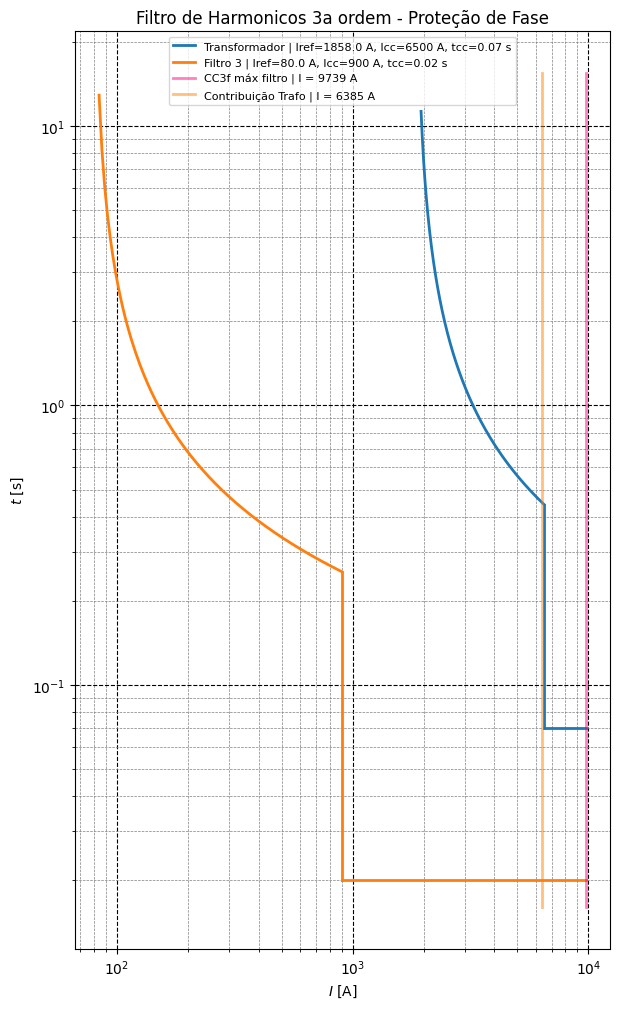

In [105]:
Iref_example = [round(1548*1.2), round(66.9*1.2)]
k_example    = [0.08, 0.09]
Icc_example  = [6500, 900]
tcc_example  = [70e-3, 20e-3]
Iref_labels  = ["Transformador", "Filtro 3"]

curto_max = [9739, 6385]
rotulos_curto_max = ['CC3f máx filtro', 'Contribuição Trafo']
cores_verticais = [(1, 0, 0.5), (1, 0.5, 0)]

plot_iec_inverse_with_tcc(
    Iref_example,
    k_example,
    Icc_example,
    tcc_example,
    Iref_labels=Iref_labels,
    curve_type="NI",
    curto_max=curto_max,
    rotulos_curto_max=rotulos_curto_max,
    cores_verticais=cores_verticais,
    titulo_grafico="Filtro de Harmonicos 3a ordem - Proteção de Fase"
)


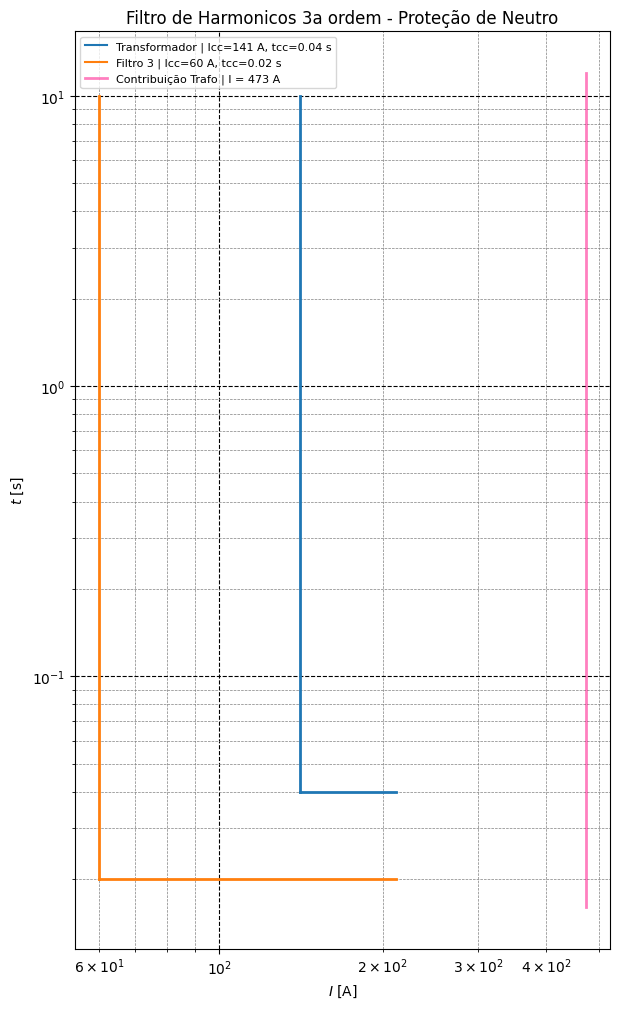

In [106]:
# ----------------------------------------------------------
# EXEMPLO 2 — SEM CURVA IEC, COM CADA L EM UMA COR
# ----------------------------------------------------------

Icc_example2  = [141, 60]
tcc_example2  = [40e-3, 20e-3]
Iref_labels2  = ["Transformador", "Filtro 3"]

curto_max2 = [473]
rotulos_curto_max2 = ['Contribuição Trafo']
cores_verticais2 = [(1, 0, 0.5)]

# CORES DAS LINHAS EM L  (AGORA FUNCIONA)
# cores_L2 = [
#     (0.2, 0.4, 1.0),   # azul
#     (0.0, 0.7, 0.0)    # verde
# ]

plot_iec_inverse_with_tcc(
    Iref_list=[],
    k_list=[],
    Icc_list=Icc_example2,
    tcc_list=tcc_example2,
    Iref_labels=Iref_labels2,
    curve_type="NI",
    curto_max=curto_max2,
    rotulos_curto_max=rotulos_curto_max2,
    cores_verticais=cores_verticais2,
    # cores_L=cores_L2,
    titulo_grafico="Filtro de Harmonicos 3a ordem - Proteção de Neutro"
)




In [107]:


# # Moderately / Very Inverse (IEC MI)
# plot_iec_inverse_with_tcc(
#     Iref_example, k_example, Icc_example, tcc_example,
#     curve_type="MI"
# )

# # Extremely Inverse (IEC EI)
# plot_iec_inverse_with_tcc(
#     Iref_example, k_example, Icc_example, tcc_example,
#     curve_type="EI"
# )